# Dataset and Augmentations Test

This notebook tests the `ISICDataset` class and the data augmentations.

In [1]:
import sys
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from torchvision.utils import make_grid

# Add the src directory to the Python path
sys.path.append(os.path.abspath('../src'))

# Force reload the module
import importlib
if 'data.datasets' in sys.modules:
    importlib.reload(sys.modules['data.datasets'])

from data.datasets import ISICDataset
from data.augmentations import get_train_transforms, get_val_transforms

print('Imports OK')


Imports OK


## Load the Dataset

In [ ]:
csv_paths = ['../data/isic2019/isic_2019_common.csv', '../data/isic2024/isic_2024_common.csv']
root_dirs = ['../data/isic2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input', '../data/isic2024/train-image/image']
img_size = 224

# Create dataset instances - one with augmentations, one without
train_dataset = ISICDataset(csv=csv_paths, root_dir=root_dirs, transform=get_train_transforms(img_size), return_image_id=True)
val_dataset = ISICDataset(csv=csv_paths, root_dir=root_dirs, transform=get_val_transforms(img_size), return_image_id=True)

# Create dataloaders with larger batch size for grid display
train_dataloader = DataLoader(train_dataset, batch_size=36, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=36, shuffle=False, num_workers=0)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

# Print label mappings (same for both datasets)
print("Unique labels:", train_dataset.unique_labels)
print("Label to num mapping:", train_dataset.label_to_num)
print("Num to label mapping:", train_dataset.num_to_label)

Number of training samples: 426390
Number of validation samples: 426390
Unique labels: ['0', '1', 'AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']
Label to num mapping: {'0': 0, '1': 1, 'AK': 2, 'BCC': 3, 'BKL': 4, 'DF': 5, 'MEL': 6, 'NV': 7, 'SCC': 8, 'VASC': 9}
Num to label mapping: {0: '0', 1: '1', 2: 'AK', 3: 'BCC', 4: 'BKL', 5: 'DF', 6: 'MEL', 7: 'NV', 8: 'SCC', 9: 'VASC'}


## Visualize Training Images with Augmentations

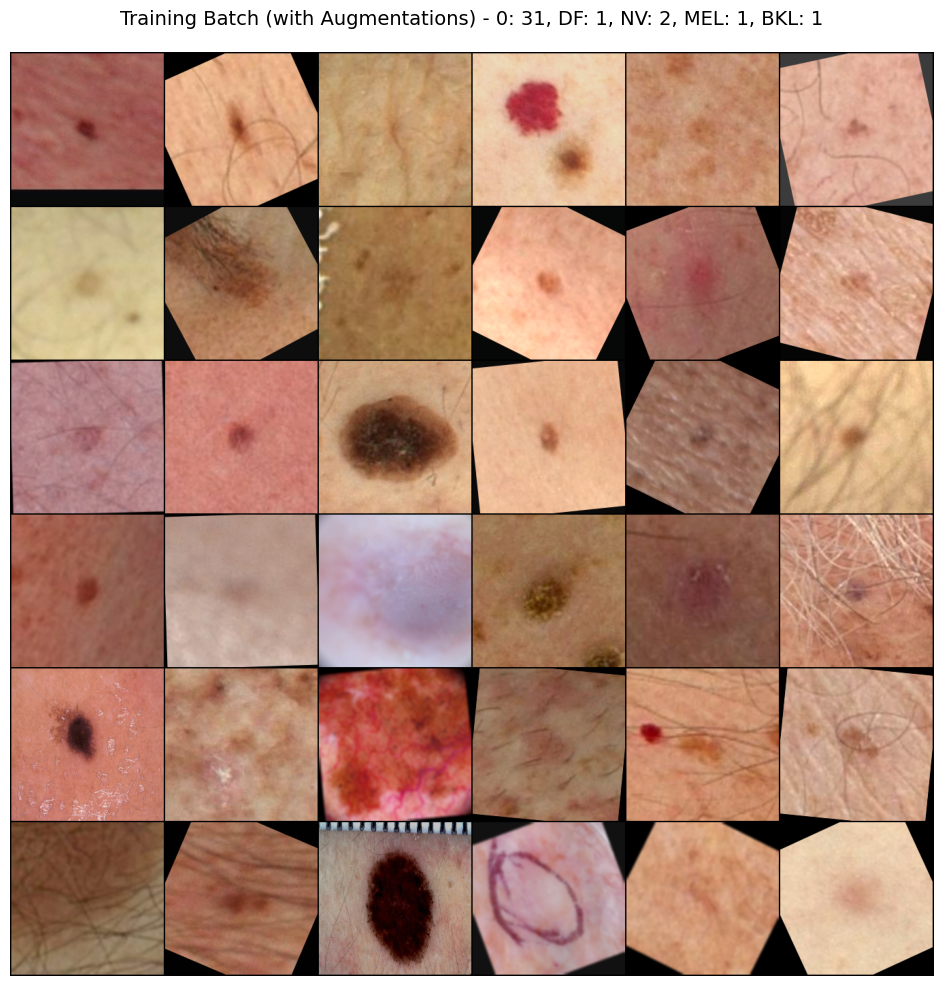

Image IDs in the batch: ['ISIC_6873441', 'ISIC_4299493', 'ISIC_4078382', 'ISIC_2705486', 'ISIC_2021998', 'ISIC_6850822', 'ISIC_2865779', 'ISIC_1190575', 'ISIC_5869860', 'ISIC_5424370', 'ISIC_1713752', 'ISIC_7349904', 'ISIC_9757471', 'ISIC_1552872', 'ISIC_9508310', 'ISIC_9813689', 'ISIC_5305005', 'ISIC_8016515', 'ISIC_6723348', 'ISIC_7153633', 'ISIC_0068848', 'ISIC_1475693', 'ISIC_7111253', 'ISIC_3041204', 'ISIC_0028030', 'ISIC_7676783', 'ISIC_0059495', 'ISIC_6165554', 'ISIC_8560410', 'ISIC_6610491', 'ISIC_5482736', 'ISIC_1178977', 'ISIC_0015146_downsampled', 'ISIC_0012323_downsampled', 'ISIC_5242170', 'ISIC_2664494']


In [3]:
def denormalize_tensor(imgs, mean=None, std=None):
    """Denormalize a batch tensor that was normalized with albumentations A.Normalize.

    imgs: torch.Tensor of shape [B, C, H, W]
    mean, std: iterables of length 3 (RGB) in 0-1 scale
    Returns: tensor [B, C, H, W] with values clamped to [0,1]
    """
    if mean is None or std is None:
        mean = [0.696, 0.522, 0.426]
        std = [0.142, 0.135, 0.128]
    mean = torch.tensor(mean, device=imgs.device, dtype=imgs.dtype).view(1, 3, 1, 1)
    std = torch.tensor(std, device=imgs.device, dtype=imgs.dtype).view(1, 3, 1, 1)
    imgs_denorm = imgs * std + mean
    return imgs_denorm.clamp(0.0, 1.0)


def imshow(inp, title=None):
    """Imshow for Tensor or numpy image/grid.

    Accepts:
      - torch.Tensor grid produced by torchvision.utils.make_grid (C,H,W)
      - torch.Tensor image (C,H,W) or batch (B,C,H,W)
      - numpy array HWC with values in [0,1]
    """
    # If it's a batch, make a grid first
    if isinstance(inp, torch.Tensor) and inp.dim() == 4:
        inp = make_grid(inp, nrow=int(np.sqrt(inp.shape[0])), padding=2, normalize=False)

    if isinstance(inp, torch.Tensor):
        arr = inp.cpu().numpy()
        # CHW -> HWC
        arr = np.transpose(arr, (1, 2, 0))
    else:
        arr = inp

    arr = np.clip(arr, 0.0, 1.0)

    plt.figure(figsize=(12, 12))
    plt.imshow(arr)
    plt.axis('off')
    if title is not None:
        plt.title(title, fontsize=14, pad=20)
    plt.pause(0.001)


# Get a batch of training data (with augmentations)
batch = next(iter(train_dataloader))
inputs, classes, images_id = batch['image'], batch['labels'], batch['meta']['image_name']

# Denormalize the inputs back to [0,1]
inputs_denorm = denormalize_tensor(inputs)

# Make a grid from batch (square-ish grid)
out = make_grid(inputs_denorm, nrow=(int(np.sqrt(inputs_denorm.shape[0]))), padding=2, normalize=False)

# Create title with class distribution
class_counts = {}
for cls in classes:
    cls_name = train_dataset.num_to_label[int(cls)]
    class_counts[cls_name] = class_counts.get(cls_name, 0) + 1

title_text = "Training Batch (with Augmentations) - " + ", ".join([f"{k}: {v}" for k, v in class_counts.items()])

imshow(out, title=title_text)
print("Image IDs in the batch:", images_id)


## Visualize Validation Images (No Augmentations)

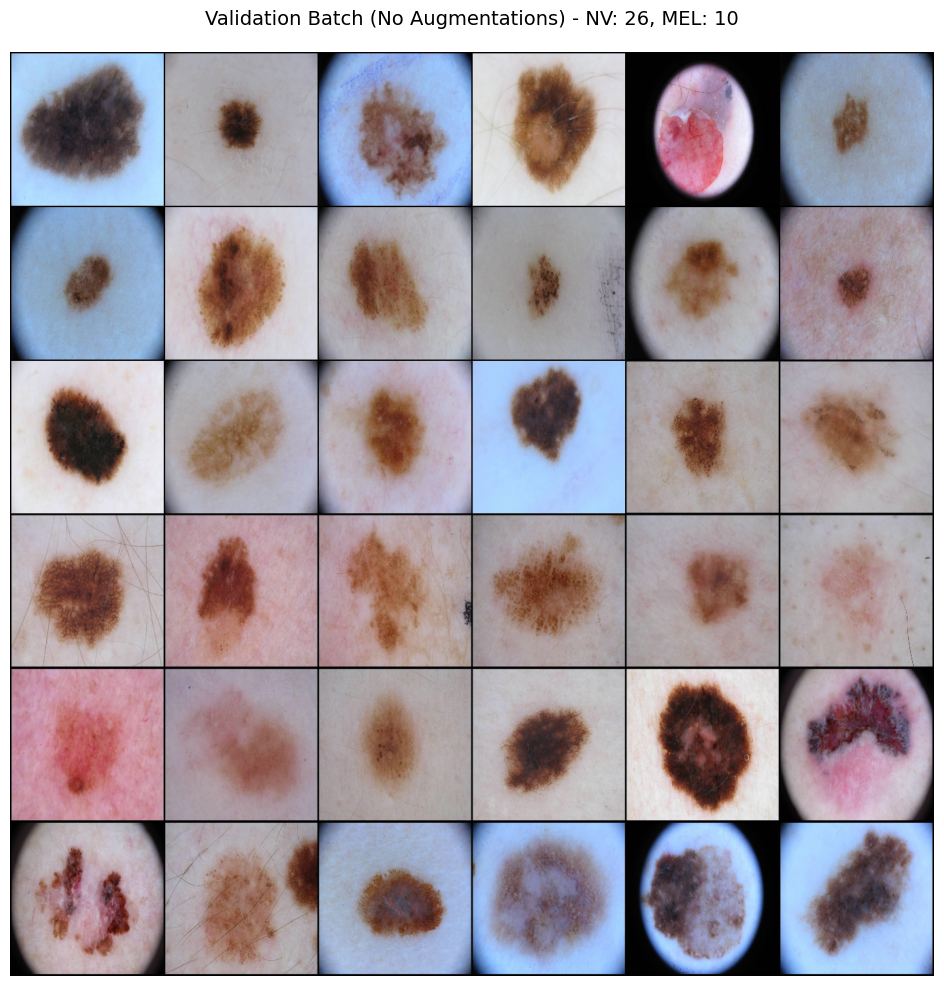

Image IDs in the batch: ['ISIC_0000000', 'ISIC_0000001', 'ISIC_0000002', 'ISIC_0000003', 'ISIC_0000004', 'ISIC_0000006', 'ISIC_0000007', 'ISIC_0000008', 'ISIC_0000009', 'ISIC_0000010', 'ISIC_0000011', 'ISIC_0000012', 'ISIC_0000013', 'ISIC_0000014', 'ISIC_0000015', 'ISIC_0000016', 'ISIC_0000017_downsampled', 'ISIC_0000018_downsampled', 'ISIC_0000019_downsampled', 'ISIC_0000020_downsampled', 'ISIC_0000021_downsampled', 'ISIC_0000022_downsampled', 'ISIC_0000023_downsampled', 'ISIC_0000024_downsampled', 'ISIC_0000025_downsampled', 'ISIC_0000026_downsampled', 'ISIC_0000027_downsampled', 'ISIC_0000028_downsampled', 'ISIC_0000029_downsampled', 'ISIC_0000030_downsampled', 'ISIC_0000031_downsampled', 'ISIC_0000032_downsampled', 'ISIC_0000034_downsampled', 'ISIC_0000035_downsampled', 'ISIC_0000036_downsampled', 'ISIC_0000037_downsampled']


In [4]:
# Get a batch of validation data (no augmentations)
batch = next(iter(val_dataloader))
inputs, classes, images_id = batch['image'], batch['labels'], batch['meta']['image_name']

# Denormalize
inputs_denorm = denormalize_tensor(inputs)

# Make a grid from batch (square-ish grid)
out = make_grid(inputs_denorm, nrow=(int(np.sqrt(inputs_denorm.shape[0]))), padding=2, normalize=False)

# Create title with class distribution
class_counts = {}
for cls in classes:
    cls_name = val_dataset.num_to_label[int(cls)]
    class_counts[cls_name] = class_counts.get(cls_name, 0) + 1

title_text = "Validation Batch (No Augmentations) - " + ", ".join([f"{k}: {v}" for k, v in class_counts.items()])

imshow(out, title=title_text)
print("Image IDs in the batch:", images_id)
